## Imports

In [183]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import nltk
import re
import networkx as nx
import wget
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import spacy
import os
from sutime import SUTime
import nereval
from nereval import Entity
from sklearn.externals import joblib 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
# if your system does not have word embeddings download it using the code below.

# url = 'http://nlp.stanford.edu/data/glove.6B.zip'
# gloveDownload = wget.download(url)
# word_embeddings = {}

## Function definitions and declarations

In [184]:
def createCols():
    global date_col,parties_col,location_col,summary_col
    date_col= []
    parties_col =[]
    location_col =[]
    summary_col = []

In [185]:
def removeStopWordsAndStem(Data):
    corpus=[]
    for i in range(0,Data['Text'].size):
        text = removeStopWords(Data['Text'][i])
        corpus.append(text)
    return corpus

In [186]:
def removeStopWords(sen):
    text= re.sub('[^a-zA-z&]',' ',sen)
    text= text.lower()
    text= text.split()
    ps= PorterStemmer();
    text= [ps.stem(word) for word in text if not word in set(stopwords.words('english'))]
    text= ' '.join(text)
    return text

In [187]:
def loadWordEmbeddings():
    word_embeddings = {}
    f = open('glove.6B/glove.6B.200d.txt', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs
    f.close()
    return word_embeddings

In [207]:
def loadClassifiers():
    classifier = joblib.load('/Users/harsha/Documents/cse635_AIR/Project/Main/Code/classifier.pkl')
    tf = joblib.load('/Users/harsha/Documents/cse635_AIR/Project/Main/Code/tf')
    return (classifier,tf)

In [221]:
def classifyData(RawData):
    corpus = removeStopWordsAndStem(RawData)
    classifier,tf = loadClassifiers()
    X= tf.transform(corpus).toarray()
    Y = classifier.predict(X)
    print(Y)
    Category =[0]*len(Y)
    riots = 0
    violence = 0
    for i in range(0,len(Y)):
        if Y[i]==1:
            Category[i] ="Riots"
            riots = riots+1
        elif Y[i]==2:
            Category[i]="Violence"
            violence = violence+1
        else:
            Category[i]="None"
    print(Category)
    RawData['CategoryPredicted'] = Category[:]
    RawData.to_csv("/Users/harsha/Documents/cse635_AIR/Project/Main/Evaluation/ClassifiedData.tsv",sep='\t',encoding="utf-8")
    return RawData

In [209]:
def loadClassifiedData():
    df = pd.read_csv('/Users/harsha/Documents/cse635_AIR/Project/Main/Evaluation/ClassifiedData.tsv', encoding = "ISO-8859-1",delimiter ='\t', quoting = 3)
    return df

In [210]:
def loadSUtime():
    __file__ = "/Users/harsha/Documents/cse635_AIR/Project/Main/Code/python-sutime-master/"
    jar_files = os.path.join(os.path.dirname(__file__), 'jars')
    sutime = SUTime(jars=jar_files, mark_time_ranges=True)
    return sutime

In [211]:
def getSentenceVectors(clean_sentences,word_embeddings):
    sentence_vectors = []
    for i in clean_sentences:
        if len(i) != 0:
            v = sum([word_embeddings.get(w, np.zeros((200,))) for w in i.split()])/(len(i.split())+0.001)
        else:
            v = np.zeros((200,))
        sentence_vectors.append(v)
    return sentence_vectors

In [212]:
def computeSimilarityMatrix(length, sentence_vectors):
    sim_mat = np.zeros([length, length])
    for i in range(length):
        for j in range(length):
            if i != j:
                sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,200), sentence_vectors[j].reshape(1,200))[0,0]
    return sim_mat

In [294]:
def tagAndAddToCol(text,reference_date,sentences,sutime):
    date=[]
    parties=[]
    location=[]
    spacy_nlp = spacy.load('en')
    j=0
    while j<len(sentences) and (len(parties)==0 or len(location)==0):
        document = spacy_nlp(sentences[j][1])
        for element in document.ents:
            print('Type: %s, Value: %s' % (element.label_, element))
            if(element.label_ in ["PERSON", "ORG"]):
                   parties.append(element)
            if(element.label_ in ["GPE"]):
                   location.append(element)
        j = j+1
    i=0
    while i<len(sentences) and (len(date)==0):
        try:
            sentence = sentences[i][1]
            date.append(sutime.parse(document,reference_date=reference_date)[0]['value'])
            if date[0] == "PAST_REF" :
                date.remove("PAST_REF")
            else:
                date_col.append(", ".join(date))
        except:
            print("exception")
            date_col.append("None")
        i = i+1
    
    parties_col.append(", ".join(repr(e) for e in parties))
    location_col.append(", ".join(repr(e) for e in location))

In [214]:
def summarizeAndTag():
    df = loadClassifiedData()
    sutime = loadSUtime()
    lim = len(df['Text'])
    word_embeddings = loadWordEmbeddings()
    for i in range(0,lim):
        print(i)
        sentences = []
        date=[]
        sentences.append(sent_tokenize(df['Text'][i]))
        sentences = [y for x in sentences for y in x]
        clean_sentences = [removeStopWords(r) for r in sentences]
        sentence_vectors = getSentenceVectors(clean_sentences,word_embeddings)
        sim_mat = computeSimilarityMatrix(len(sentences),sentence_vectors)
        nx_graph = nx.from_numpy_array(sim_mat)
        scores = nx.pagerank(nx_graph,max_iter=100)
        ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
        summary = ranked_sentences[0][1]+ranked_sentences[1][1]
#         print(ranked_sentences)
#         print(len(ranked_sentences))
        summary_col.append(summary)
        tagAndAddToCol(df['Text'][i],df['Date'][i],ranked_sentences,sutime)

In [248]:
def writeToDisk(df):
    df['Summary'] = summary_col[:]
#     df['Event_Date'] = date_col[:]
    df['Event_Location'] = location_col[:]
    df['Parites_Involved']= parties_col[:]
    df.to_csv("Summarized.csv", encoding="utf-8")

In [250]:
def main():
    createCols()
    col = ['Text','Date']
#     RawData = pd.DataFrame(data,columns=['Text','Date'])
    RawData = pd.read_csv('/Users/harsha/Documents/cse635_AIR/Project/Main/Data/Evaluate.tsv',encoding = "ISO-8859-1",skipinitialspace=True,delimiter='\t', quoting= 3,usecols=col)
    display(HTML(RawData.to_html()))
    RawData = classifyData(RawData)
#     summarizeAndTag()
#     writeToDisk(RawData)

In [ ]:
if __name__ == '__main__':
    main()

## Generate Metrics

In [288]:
from sklearn.metrics import confusion_matrix
y_test= Predicted['Y_test']
y_pred = Predicted['Y_Pred']
cm = confusion_matrix(y_test,y_pred)

In [289]:
y_test = y_test.as_matrix()
y_pred = y_pred.as_matrix()
y_test = y_test.reshape((1, -1))
y_pred = y_pred.reshape((1, -1))

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [290]:
cm

array([[11,  9,  0],
       [ 0, 33,  6],
       [ 0, 12, 28]])

In [279]:
type(y_test)

numpy.ndarray

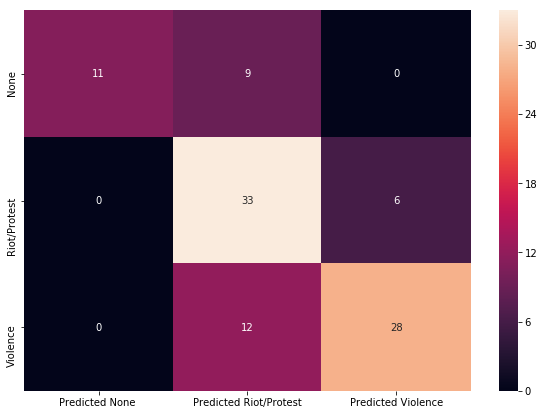

In [292]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ["None", "Riot/Protest","Violence"],
                  columns = ["Predicted None ", "Predicted Riot/Protest","Predicted Violence"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g')